In [11]:
import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import os

In [2]:
def plot_cdf(input_path):
    df = pd.read_csv(input_path)

    if 'wind_duration_ns' not in df.columns:
        raise ValueError(
            "Input CSV must contain a 'wind_duration_ns' column"
        )

    # Convert to milliseconds
    durations_ms = df['wind_duration_ns'] / 1e6

    # Compute and print quantiles
    q_levels = [0.0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1.0]
    quantiles = np.quantile(durations_ms, q_levels, method="lower")
    print("Quantiles of window durations (ms):")
    for q, val in zip(q_levels, quantiles):
        label = f"{int(q*100)}th percentile" if q != 1.0 else "100th percentile"
        print(f"{label}: {val:.3f} ms")


    # Compute CDF
    sorted_vals = np.sort(durations_ms.values)
    cdf_vals = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
    
    plt.figure(figsize=(8, 6))
    plt.rcParams.update({'font.size': 14})
    # plt.xscale("log")
    plt.xlabel("Window size (ms)")
    plt.ylabel("CDF")
    plt.grid(True)
    plt.yticks([0, 0.25, 0.5, 0.75, 1.0],
               ['0', '0.25', '0.5', '0.75', '1'])
    plt.tight_layout()
    plt.title('CDF of Window Sizes for Rank')

    plt.plot(sorted_vals, cdf_vals)
    # plt.savefig('rank0_windows_cdf.png')
    plt.show()

In [9]:
def plot_size_to_count_window(csv_path: str) -> str:
    """
    Make a bar+line plot where:
      - X axis: size (MiB) from 'parallelism_group_before_wind_aggregate_size(bytes)'
      - Left Y: count of windows with that size (integer axis, hatched bars)
      - Right Y: average window duration (ms) for that size group
    Also prints, for each size MiB: the count and avg window size (ms).
    """
    df = pd.read_csv(csv_path)

    size_col = "parallelism_group_before_wind_aggregate_size(bytes)"
    dur_col  = "wind_duration_ns"
    if size_col not in df.columns or dur_col not in df.columns:
        raise ValueError(f"CSV must contain '{size_col}' and '{dur_col}' columns.")

    # Convert to MiB + ms
    df["size_mib"] = (pd.to_numeric(df[size_col], errors="coerce") / (2**20))
    df["size_mib_round"] = df["size_mib"].round().astype("Int64")  # bucket by rounded MiB
    df["wind_duration_ms"] = pd.to_numeric(df[dur_col], errors="coerce") / 1e6
    df = df.dropna(subset=["size_mib_round", "wind_duration_ms"])

    grouped = df.groupby("size_mib_round")["wind_duration_ms"]
    counts = grouped.count()
    avgs   = grouped.mean()

    if counts.empty:
        raise ValueError("No valid data after parsing size and duration columns.")

    sizes_sorted = sorted(counts.index.tolist())
    counts_list  = [int(counts[s]) for s in sizes_sorted]
    avgs_list    = [float(avgs[s]) for s in sizes_sorted]
    labels       = [str(int(s)) for s in sizes_sorted]

    # Print a summary table
    print("Size (MiB)\tCount\tAvg window (ms)")
    for s in sizes_sorted:
        print(f"{int(s):>9}\t{int(counts[s]):>5}\t{avgs[s]:.3f}")

    plt.rcParams.update({'font.size': 12})
    fig, ax1 = plt.subplots(figsize=(6.0, 4.0))
    x = range(len(sizes_sorted))

    # Left Y: counts (bars, hatched style; transparent fill)
    ax1.bar(
        x, counts_list,
        hatch='/', edgecolor='black', facecolor='none',
        linewidth=1.2, label="Count"
    )
    ax1.set_xlabel("Size (MiB)")
    ax1.set_ylabel("Count")
    ax1.set_xticks(list(x))
    ax1.set_xticklabels(labels)
    ax1.yaxis.set_major_locator(MaxNLocator(integer=True))  # integer tick marks
    ax1.tick_params(axis='y')

    # Right Y: average window duration (line)
    ax2 = ax1.twinx()
    ax2.plot(x, avgs_list, linestyle='--', marker='o', label="Avg window (ms)")
    ax2.set_ylabel("Avg window size (ms)")
    ax2.tick_params(axis='y')

    # Legends (place both neatly)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    fig.tight_layout()

    plt.show()


Quantiles of window durations (ms):
0th percentile: 70.547 ms
25th percentile: 85.235 ms
50th percentile: 421.955 ms
75th percentile: 1365.926 ms
90th percentile: 1386.921 ms
95th percentile: 1403.004 ms
99th percentile: 1415.883 ms
100th percentile: 1422.782 ms


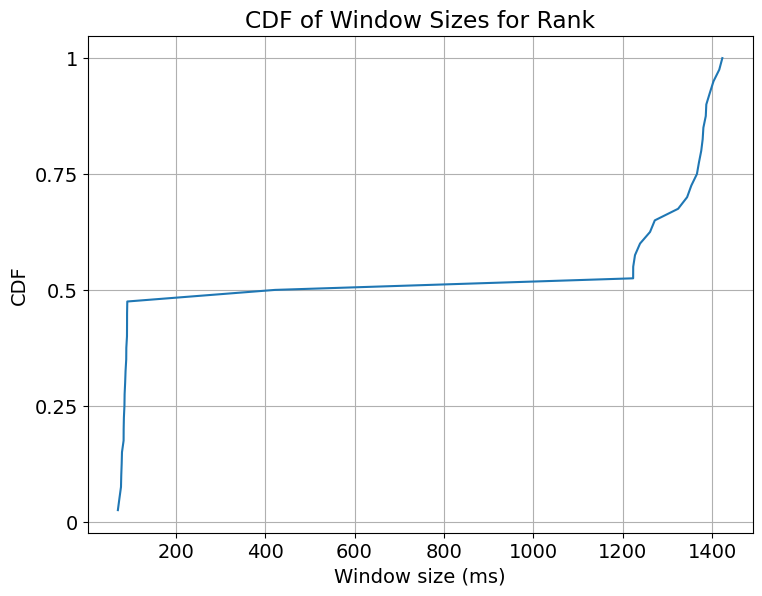

In [3]:
plot_cdf("../traces/node0_rank0_windows.csv")

Size (MiB)	Count	Avg window (ms)
       80	   19	1336.501
      112	    1	1353.342
      957	    1	421.955
     2872	   19	84.136


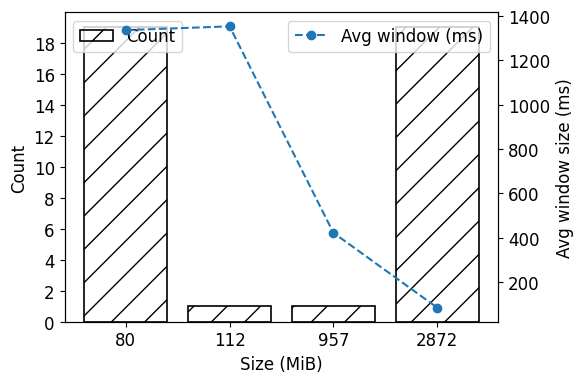

In [12]:
plot_size_to_count_window("../traces/node0_rank0_windows.csv")

Previous CDF per rank for reference:
https://github.com/chuhan-ouyang/torchtitan/blob/nsys/windows/traces-scripts/trace-events/all_ranks_dp_2_tp_4_pp_2_events_processed_window_cdf.png